In [373]:
import sklearn
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA ,
    QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from ISLP import load_data
from numpy.typing import ArrayLike

In [2]:
def confusion_table(true_labels: ArrayLike,
                    predicted_labels: ArrayLike) -> pd.DataFrame:
    """
    Return a data frame version of confusion 
    matrix with rows given by predicted label
    and columns the truth.
    

    Args:
        true_labels (ArrayLike): True labels of your data
        predicted_labels (ArrayLike): Predicted labels of your data

    Returns:
        pd.DataFrame: confusion matrix with rows given by predicted label and columns the truth. The diagonal of the matrix indicates correct predictions.
    """

    labels = sorted(np.unique(list(true_labels) + list(predicted_labels)))
    cm = sklearn.metrics.confusion_matrix(true_labels,
                          predicted_labels)
    df = pd.DataFrame(cm.T, columns=labels) # swap rows and columns
    df.index = pd.Index(labels, name='Predicted')
    df.columns.name = 'Truth'
    return df

# Logistic Regression

In [3]:
stock_market = load_data('Smarket')

In [4]:
stock_market.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [5]:
# Using a pandas function
stock_market.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<Axes: >

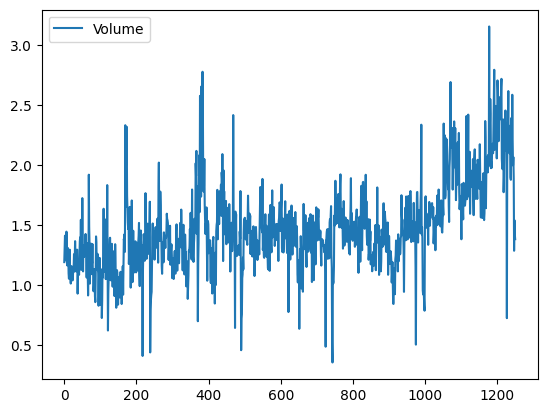

In [6]:
stock_market.plot(y='Volume')

In [7]:
all_vars = stock_market.columns.drop(['Today', 'Direction', 'Year'])
X = sm.add_constant(stock_market[all_vars])
y = stock_market.Direction == 'Up'
glm = sm.GLM(y,
    X,
    family=sm.families.Binomial())
results = glm.fit()

In [8]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.1260,0.241,-0.523,0.601,-0.598,0.346
Lag1,-0.0731,0.050,-1.457,0.145,-0.171,0.025
Lag2,-0.0423,0.050,-0.845,0.398,-0.140,0.056
Lag3,0.0111,0.050,0.222,0.824,-0.087,0.109
Lag4,0.0094,0.050,0.187,0.851,-0.089,0.107
Lag5,0.0103,0.050,0.208,0.835,-0.087,0.107
Volume,0.1354,0.158,0.855,0.392,-0.175,0.446


In [9]:
results.params

const    -0.126000
Lag1     -0.073074
Lag2     -0.042301
Lag3      0.011085
Lag4      0.009359
Lag5      0.010313
Volume    0.135441
dtype: float64

In [10]:
results.pvalues

const     0.600700
Lag1      0.145232
Lag2      0.398352
Lag3      0.824334
Lag4      0.851445
Lag5      0.834998
Volume    0.392404
dtype: float64

In [11]:
# Show predictions
probs = results.predict()
probs[:10]


array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [12]:
labels = np.array(['Down']*1250)
labels[probs >0.5] = "Up"

In [13]:
labels

array(['Up', 'Down', 'Down', ..., 'Up', 'Up', 'Up'], dtype='<U4')

In [14]:
c = sklearn.metrics.confusion_matrix(y_true =stock_market.Direction , y_pred=labels) 

In [15]:
c

array([[145, 457],
       [141, 507]])

In [16]:
stock_market.Direction.value_counts()

Up      648
Down    602
Name: Direction, dtype: int64

In [17]:
confusion_table(stock_market.Direction, labels)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [18]:
# Percent of times we are correctly predicting
np.mean(labels == stock_market.Direction)

0.5216

## Making a training and test set

In [19]:
# creates a pd.core.series.Series of True, False
train = (stock_market.Year < 2005)
# pd.DataFrame.loc returns only the locations of interest based on True, False input
stock_market_train = stock_market.loc[train]
# ~ is used to negate or the opposite of 
stock_market_test = stock_market.loc[~train]
stock_market_test.shape

(252, 9)

In [20]:
stock_market_train.shape

(998, 9)

In [21]:
# X and y are the same as stock market, but already separated to have the
# columns we care about. You can use the same commands above to 
# create the training and test set from them.
X_train , X_test = X.loc[train], X.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]

In [22]:
glm_train = sm.GLM(y_train ,
                    X_train ,
                    family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(X_test)

In [23]:
direction = stock_market.Direction
labels_train , labels_test = direction.loc[train], direction.loc[~train]

In [24]:
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
# Note my function has the parameters in the same order
# as sklearn does
confusion_table(true_labels=labels_test, predicted_labels=labels)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [25]:
np.mean(labels == labels_test), np.mean(labels != labels_test)

(0.4801587301587302, 0.5198412698412699)

# Linear Discriminant Analysis

In [26]:
lda = LDA(store_covariance=True)

In [27]:
# only want lag1 and lag2 for this example
X_train = X_train[['Lag1','Lag2']]

In [28]:
X_test = X_test[['Lag1','Lag2']]

In [29]:
X_train

,Lag1,Lag2
0,0.381,-0.192
1,0.959,0.381
2,1.032,0.959
3,-0.623,1.032
4,0.614,-0.623
...,...,...
993,0.046,0.342
994,-0.431,0.046
995,0.715,-0.431
996,-0.007,0.715


In [30]:
labels_train

0        Up
1        Up
2      Down
3        Up
4        Up
       ... 
993    Down
994      Up
995    Down
996      Up
997    Down
Name: Direction, Length: 998, dtype: object

In [31]:
lda.fit(X_train, labels_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [32]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [33]:
lda.feature_names_in_

array(['Lag1', 'Lag2'], dtype=object)

In [34]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

### The above explained

Column order is in the order of `lda.features_names_in_` and row order is in the order of  `lda.classes_`

$\mu_k$ is a class specific vector, i.e. you should have a mean for each parameter for each class.

In this case $\vec{\mu_{up}}=\begin{bmatrix}=-0.0395\\-0.0313\end{bmatrix}$

and 

$\vec{\mu_{down}}=\begin{bmatrix}=0.0428\\0.0339\end{bmatrix}$

In [35]:
lda.priors_

array([0.49198397, 0.50801603])

Priors $\hat{\pi_k}$ calculated from the training data set, which is the fraction of training data set that belong to the kth class. In this case 49.5% of the training data set where classified as "Down".

In [36]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

These values provide the linear combination of Lag1 and Lag2 that are used
to form the LDA decision rule. In other words, these are the multipliers of
the elements of X = x in (4.24). If −0.64 × Lag1 − 0.51 × Lag2 is large,
then the LDA classifier will predict a market increase, and if it is small,
then the LDA classifier will predict a market decline

In [37]:
lda_pred = lda.predict(X_test)

In [38]:
lda_pred[0:4]

array(['Up', 'Up', 'Up', 'Up'], dtype='<U4')

In [39]:
confusion_table(labels_test, lda_pred)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [40]:
lda_prob = lda.predict_proba(X_test)

In [41]:
lda_prob[0:5]
# returns the probabilities of each class, i.e. probability of going down and probability of going up

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234]])

In [42]:
# now use NP where to apply a threshold. This outputs true because
# when you use lda.predict it defaults to 50% threshold

np.all(np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred)

True

In [43]:
# Just shows you how the inside part of the statement looks and compares to 
# `lda.pred`, which is above
np.where(lda_prob[:,1] >= 0.5, 'Up','Down')[0:4]

array(['Up', 'Up', 'Up', 'Up'], dtype='<U4')

# Quadratic Discriminant Analysis

In [44]:
qda = QDA(store_covariance=True)
qda.fit(X_train , labels_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [45]:
print(qda.feature_names_in_)
print(qda.classes_)

['Lag1' 'Lag2']
['Down' 'Up']


In [46]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [47]:
qda.priors_

array([0.49198397, 0.50801603])

In [48]:
# Estimates covariance because you are no longer assuming constant
# One co-variance matrix per class
qda.covariance_

[array([[ 1.50662277, -0.03924806],
        [-0.03924806,  1.53559498]]),
 array([[ 1.51700576, -0.02787349],
        [-0.02787349,  1.49026815]])]

In [49]:
qda_pred = qda.predict(X_test)
confusion_table(labels_test, qda_pred)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [50]:
np.mean(qda_pred == labels_test)

0.5992063492063492

Correctly predict approximately 60% of the time

# Naive Bayes

In [51]:
NB = GaussianNB()
NB.fit(X_train , labels_train)

GaussianNB()

In [52]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [53]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [54]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [55]:
#TODO determine the calculation for each sigma_ij
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

The GaussianNB() function calculates variances using the 1/n formula

In [56]:
nb_labels = NB.predict(X_test)
confusion_table(labels_test, nb_labels)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [57]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

# K-nearest neighbors

In [58]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train , labels_train)
knn1_pred = knn1.predict(X_test)
confusion_table(labels_test, knn1_pred)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [59]:
np.mean(knn1_pred == labels_test)

0.5

In [60]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train , labels_train)
knn3_pred = knn3.predict(X_test)
confusion_table(labels_test, knn3_pred)

Truth,Down,Up
Predicted,,
Down,48,55
Up,63,86


In [61]:
np.mean(knn3_pred == labels_test)

0.5317460317460317

## KNN with different dataset

In [62]:
caravan = load_data('Caravan')
caravan.Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [63]:
# create a vector for the response
purchase = caravan.Purchase

In [64]:
feature_df = caravan.drop(columns=['Purchase'])

when using knn, scale of explanatory variables matter, e.g. you want them to be of the same magnitude otherwise some variables will reduce the impact of others, e.g. salary and age.

In [65]:
# give the variables a mean of 0 and standard deviation of 1
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)

In [66]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [67]:
feature_df

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,2,0,0,0,1,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,0,1,0,0,0,0,0
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


In [68]:
feature_std = pd.DataFrame(X_std, columns=feature_df.columns)
(feature_std.mean(),feature_std.std())

(MOSTYPE    -7.749822e-17
 MAANTHUI   -1.614038e-16
 MGEMOMV    -2.099164e-16
 MGEMLEEF    2.154084e-16
 MOSHOOFD   -2.929067e-17
                 ...     
 AZEILPL    -6.102222e-19
 APLEZIER   -1.830667e-18
 AFIETS      0.000000e+00
 AINBOED     3.905422e-17
 ABYSTAND    3.356222e-18
 Length: 85, dtype: float64,
 MOSTYPE     1.000086
 MAANTHUI    1.000086
 MGEMOMV     1.000086
 MGEMLEEF    1.000086
 MOSHOOFD    1.000086
               ...   
 AZEILPL     1.000086
 APLEZIER    1.000086
 AFIETS      1.000086
 AINBOED     1.000086
 ABYSTAND    1.000086
 Length: 85, dtype: float64)

In [69]:
# split the data

(X_train, X_test , y_train , y_test) = train_test_split(feature_std, purchase, test_size=1000, random_state=0)

In [70]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train , y_train)
knn1_pred = knn1.predict(X_test)

In [71]:
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

error rate on the 1,000 test observations is about 11%

In [72]:
confusion_table(y_test, knn1_pred)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


Of those predicted to purchase insurance $53 + 9 = 62$, 9 actually purchase, that means we had a 14% success rate in that category. The null model for the data set is 6%, because of the data only 6% actually purchased insurance. Maybe as a company you would only want to target those you think would say yes versus an entire population.

In [73]:
purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [74]:
348/(5474+348)

0.05977327378907592

## Tuning parameters

In [75]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train , y_train).predict(X_test)
    C = confusion_table(y_test, knn_pred)
    templ = ('K={0:d}: # predicted to rent: {1:>2}, # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes', 'Yes']
    print(templ.format(K,pred, did_rent, did_rent/pred))

K=1: # predicted to rent: 62, # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6, # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20, # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4, # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7, # who did rent 1, accuracy 14.3%


In [76]:
C

Truth,No,Yes
Predicted,,
No,927,66
Yes,6,1


In [77]:
C.loc['Yes','Yes']

1

# sklearn logistic regression

In [78]:
logit = LogisticRegression(C=1e10 , solver='liblinear')
logit.fit(X_train , y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 5, 'Yes', 'No')
confusion_table(y_test, logit_labels)

Truth,No,Yes
Predicted,,
No,933,67
Yes,0,0


Note, this is using a cutoff of 50%, which means we never predict anyone to but insurance, we can change to 25%

In [79]:
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(y_test, logit_labels)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [80]:
9/(20+9)

0.3103448275862069

## Make an ROC curve and calculate AUC

In [81]:
default = load_data('Default')

In [82]:
default.shape

(10000, 4)

In [83]:
default.columns

Index(['default', 'student', 'balance', 'income'], dtype='object')

In [84]:
default = pd.get_dummies(default, columns = ['student'], drop_first=True)

In [85]:
default_response = default['default']
feature_df = default.drop(labels=['default'], axis=1)

In [86]:
default_response.value_counts()

No     9667
Yes     333
Name: default, dtype: int64

In [87]:
lda = LDA(store_covariance=True)
lda.fit(feature_df, default_response)

LinearDiscriminantAnalysis(store_covariance=True)

In [88]:
lda_pred = lda.predict(feature_df)

In [89]:
lda.classes_

array(['No', 'Yes'], dtype='<U3')

In [90]:
confusion_table(true_labels=default_response, predicted_labels=lda_pred)

Truth,No,Yes
Predicted,,
No,9645,254
Yes,22,79


In [91]:
lda_probs = lda.predict_proba(feature_df)

In [92]:
# No is first in the lda.classes_ so it must be 1
int_response = np.where(default_response=='No',1,0)

In [100]:
lda_probs

array([[9.96776483e-01, 3.22351679e-03],
       [9.97310469e-01, 2.68953132e-03],
       [9.85291400e-01, 1.47085998e-02],
       ...,
       [9.93867912e-01, 6.13208754e-03],
       [8.62826402e-01, 1.37173598e-01],
       [9.99846451e-01, 1.53549027e-04]])

In [99]:
lda_probs[:,0]

array([0.99677648, 0.99731047, 0.9852914 , ..., 0.99386791, 0.8628264 ,
       0.99984645])

In [102]:
# You use lda_probs[:,0] because that is the probability associated with the first class
# which in this case is 'No'
fpr, tpr, _ = sklearn.metrics.roc_curve(int_response, lda_probs[:,0])

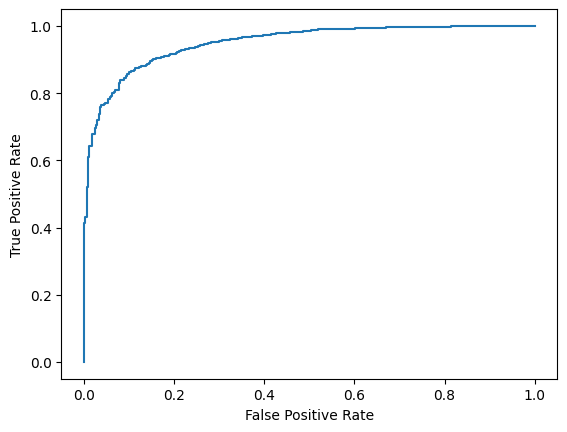

In [94]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [95]:
auc = metrics.roc_auc_score(int_response, lda_probs[:,0])
auc

0.9495202246831502

In [103]:
bike_data = load_data('Bikeshare')

In [105]:
bike_data.columns

Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'bikers'],
      dtype='object')

In [106]:
bike_data.shape

(8645, 15)

In [107]:
bike_response = bike_data['bikers']

In [119]:
bike_explanatory = sm.add_constant(bike_data[['mnth', 'hr', 'workingday', 'temp','weathersit']])

In [120]:
bike_explanatory.head()

,const,mnth,hr,workingday,temp,weathersit
0,1.0,Jan,0,0,0.24,clear
1,1.0,Jan,1,0,0.22,clear
2,1.0,Jan,2,0,0.22,clear
3,1.0,Jan,3,0,0.24,clear
4,1.0,Jan,4,0,0.24,clear


In [121]:
bike_explanatory = pd.get_dummies(bike_explanatory,columns = ['mnth','weathersit','hr'], drop_first=True)

In [122]:
bike_lm = sm.OLS(bike_response,bike_explanatory).fit()

In [123]:
bike_lm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-68.6317,5.307,-12.932,0.000,-79.035,-58.229
workingday,1.2696,1.784,0.711,0.477,-2.228,4.768
temp,157.2094,10.261,15.321,0.000,137.095,177.324
mnth_Feb,6.8452,4.287,1.597,0.110,-1.559,15.250
mnth_March,16.5514,4.301,3.848,0.000,8.120,24.983
mnth_April,41.4249,4.972,8.331,0.000,31.678,51.172
mnth_May,72.5571,5.641,12.862,0.000,61.499,83.615
mnth_June,67.8187,6.544,10.364,0.000,54.992,80.646
mnth_July,45.3245,7.081,6.401,0.000,31.444,59.205
mnth_Aug,53.2430,6.640,8.019,0.000,40.227,66.259


In [127]:
from ISLP.models import contrast
from ISLP.models import (ModelSpec as MS,
summarize)

In [126]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [129]:
X2 = MS([mnth_encode ,
    hr_encode ,
    'workingday',
    'temp','weathersit']).fit_transform(bike_data)

In [131]:
bike_explanatory.head()

,const,workingday,temp,mnth_Feb,mnth_March,mnth_April,mnth_May,mnth_June,mnth_July,mnth_Aug,...,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
0,1.0,0,0.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,0.22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0.22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
list(set(X2['mnth[Feb]']))

[0.0, 1.0, -1.0]

In [136]:
X2.columns

Index(['intercept', 'mnth[Jan]', 'mnth[Feb]', 'mnth[March]', 'mnth[April]',
       'mnth[May]', 'mnth[June]', 'mnth[July]', 'mnth[Aug]', 'mnth[Sept]',
       'mnth[Oct]', 'mnth[Nov]', 'hr[0]', 'hr[1]', 'hr[2]', 'hr[3]', 'hr[4]',
       'hr[5]', 'hr[6]', 'hr[7]', 'hr[8]', 'hr[9]', 'hr[10]', 'hr[11]',
       'hr[12]', 'hr[13]', 'hr[14]', 'hr[15]', 'hr[16]', 'hr[17]', 'hr[18]',
       'hr[19]', 'hr[20]', 'hr[21]', 'hr[22]', 'workingday', 'temp',
       'weathersit[cloudy/misty]', 'weathersit[heavy rain/snow]',
       'weathersit[light rain/snow]'],
      dtype='object')

In [192]:
X2[X2['mnth[Nov]']==0]

,intercept,mnth[Jan],mnth[Feb],mnth[March],mnth[April],mnth[May],mnth[June],mnth[July],mnth[Aug],mnth[Sept],...,hr[18],hr[19],hr[20],hr[21],hr[22],workingday,temp,weathersit[cloudy/misty],weathersit[heavy rain/snow],weathersit[light rain/snow]
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.24,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.22,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.22,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.24,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.24,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1,0.40,0.0,0.0,0.0
7181,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1,0.40,0.0,0.0,0.0
7182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1,0.36,1.0,0.0,0.0
7183,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1,0.36,1.0,0.0,0.0


In [155]:
bike_data[bike_data['mnth']=='Jan']

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
0,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0000,3,13,16
1,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0000,8,32,40
2,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0000,5,27,32
3,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0000,3,10,13
4,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,1,Jan,31,19,0,1,1,clear,0.30,0.3182,0.61,0.1045,3,108,111
684,1,Jan,31,20,0,1,1,light rain/snow,0.16,0.1667,0.59,0.1642,0,78,78
685,1,Jan,31,21,0,1,1,light rain/snow,0.16,0.1970,0.59,0.0896,3,53,56
686,1,Jan,31,22,0,1,1,cloudy/misty,0.16,0.1818,0.59,0.1045,0,34,34


variable = 1 if it is that month

= 0 if it is any month but itself or DEC

=-1 if it is the month of dec

In [344]:
bike_explanatory_2 = bike_data[['mnth', 'hr', 'workingday', 'temp','weathersit']]

In [342]:
def encode_sum(df,column):
    df = df.copy()
    if df[column].dtype.name == 'category':
        cats = list(df[column].unique())
        for cat in cats[:len(cats)-1]:
            df['{}_{}'.format(column, cat)] = np.where(df[column]==cat, 1, \
                np.where(df[column] == cats[len(cats)-1], -1, 0))
        df = df.drop(column, axis=1)
    else:
        raise ValueError('Function requires column to be "category" and you provided {} column' \
                         .format(df[column].dtype.name))
    return df

In [346]:
df = encode_sum(bike_explanatory_2, 'mnth')

In [335]:
df = encode_sum(df, 'hr')

In [337]:
df = pd.get_dummies(df, columns=['weathersit'], drop_first=True)

In [338]:
X2 = sm.add_constant(df)

In [340]:
bike_lm_2 = sm.OLS(bike_response, X2).fit()

In [341]:
bike_lm_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,73.5974,5.132,14.340,0.000,63.537,83.658
workingday,1.2696,1.784,0.711,0.477,-2.228,4.768
temp,157.2094,10.261,15.321,0.000,137.095,177.324
mnth_Jan,-46.0871,4.085,-11.281,0.000,-54.096,-38.079
mnth_Feb,-39.2419,3.539,-11.088,0.000,-46.179,-32.304
mnth_March,-29.5357,3.155,-9.361,0.000,-35.721,-23.351
mnth_April,-4.6622,2.741,-1.701,0.089,-10.034,0.710
mnth_May,26.4700,2.851,9.285,0.000,20.882,32.058
mnth_June,21.7317,3.465,6.272,0.000,14.939,28.524
mnth_July,-0.7626,3.908,-0.195,0.845,-8.424,6.899


# Poisson Regression

In [349]:
lm_pois = sm.GLM(bike_response, X2, family=sm.families.Poisson()).fit()

In [353]:
summary_pois = lm_pois.summary().tables[1]

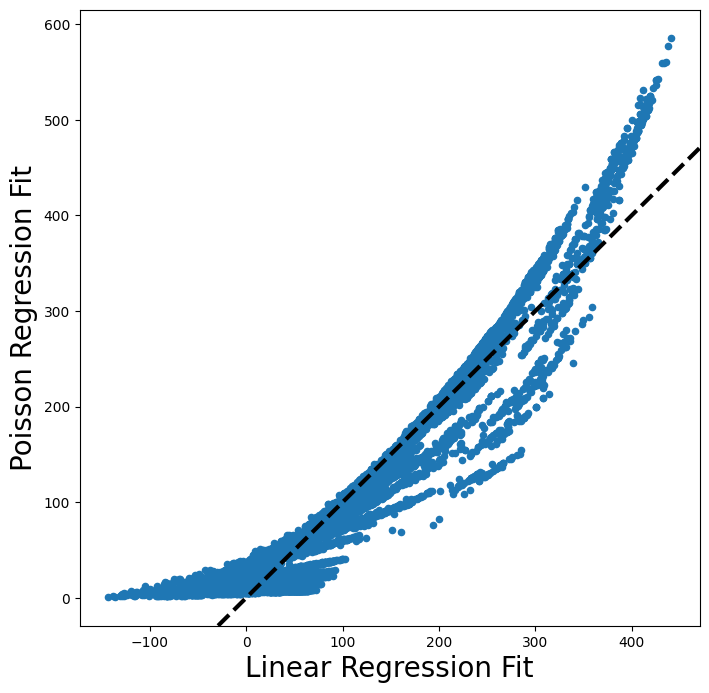

In [361]:
fig , ax = plt.subplots(figsize=(8, 8))
ax.scatter(bike_lm_2.fittedvalues ,
            lm_pois.fittedvalues ,
            s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3,linestyle='--', slope=1)

# Box plots

<Axes: xlabel='mnth', ylabel='bikers'>

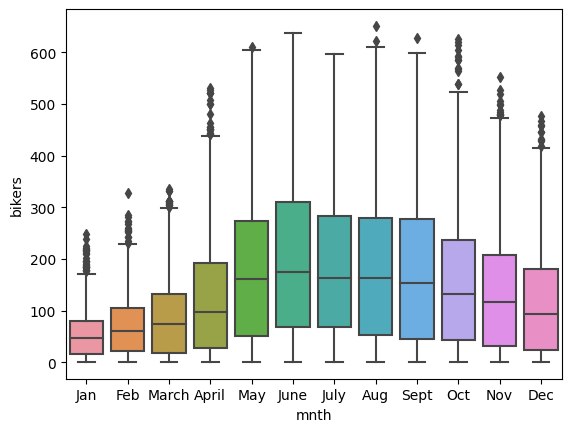

In [374]:
sns.boxplot(data = bike_data, y = 'bikers', x = 'mnth')

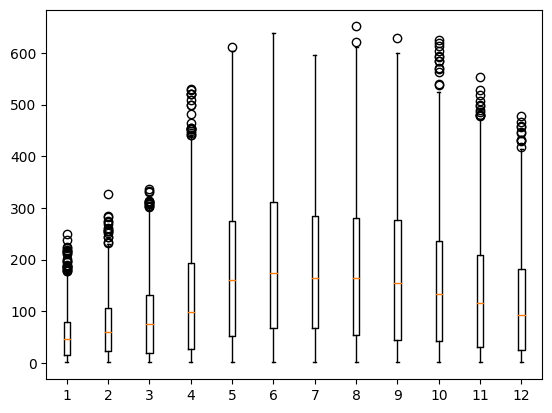

In [419]:
count = 0
for n, grp in bike_data[['bikers','mnth']].groupby('mnth'):
    count+=1
    plt.boxplot(x='bikers', data=grp, positions=[count])

<Axes: title={'center': 'bikers'}, xlabel='mnth'>

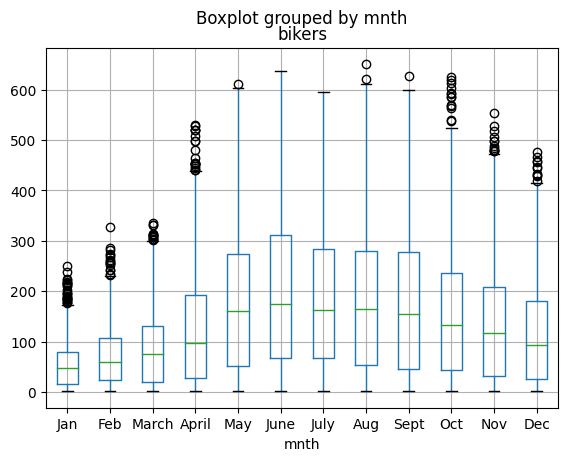

In [424]:
bike_data.boxplot(column='bikers', by='mnth')